# Compute reference embeddings

In [1]:
from setup import neurotransmitters, model_size, device, feat_dim, resize_size, dataset_path, curated_idx, few_shot_transforms, model
from setup import tqdm, torch, np, os, h5py, sns, plt, tqdm, Trans, Image, chain
from setup import cosine_similarity, euclidean_distances
from perso_utils import get_fnames, load_image, get_latents
from DINOSim import DinoSim_pipeline, diplay_features
from napari_dinosim.utils import get_img_processing_f
# Create an instance of the pipeline (not just assigning the class)

few_shot = DinoSim_pipeline(model,
                            model.patch_size,
                            device,
                            get_img_processing_f(resize_size),
                            feat_dim, 
                            dino_image_size=resize_size
                            )


Device: cpu


Using cache found in /home/tomwelch/.cache/torch/hub/facebookresearch_dinov2_main
/home/tomwelch/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/home/tomwelch/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/home/tomwelch/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")


Model loaded


In [4]:
saved_ref_embeddings = False

data_aug = False
k = 10

if saved_ref_embeddings == False:

    files, labels = zip(*get_fnames()) 

    if data_aug:    
        nb_transformations = len(few_shot_transforms)
        
        # Preload images and metadata once
        good_images = []
        transformed_coordinates = []

        for idx in curated_idx:
            img, coord_x, coord_y = load_image(files[idx])
            good_images.append(img.transpose(1,2,0))
            transformed_coordinates.append([(0, coord_x, coord_y)] * nb_transformations)

        transformed_images = []
        for image in good_images:
            transformed = [t(image).permute(1,2,0) for t in few_shot_transforms]
            transformed_images.extend(transformed)

        for j, img in enumerate(transformed_images):
            if img.shape != torch.Size([130, 130, 1]):
                h, w = img.shape[:2]
                h_diff = (130 - h) // 2
                w_diff = (130 - w) // 2
                padded_img = torch.zeros(130, 130, 1)
                padded_img[h_diff:h+h_diff, w_diff:w+w_diff, :] = img
                transformed_images[j] = padded_img
                
        batch_size = int(len(curated_idx)/len(neurotransmitters)*nb_transformations) # nb of images in per class
        good_datasets = [transformed_images[i:i+batch_size] for i in range(0,len(transformed_images),batch_size)]
        good_datasets = np.array(good_datasets)
        
        transformed_coordinates = np.vstack(transformed_coordinates)
        good_coordinates = [transformed_coordinates[i:i+batch_size] for i in range(0,len(transformed_coordinates),batch_size)]

    else:

        imgs_coords = [load_image(files[idx]) for idx in curated_idx]
        imgs, xs, ys = zip(*imgs_coords)

        batch_size = int(len(curated_idx)/len(neurotransmitters))
        imgs = [imgs[i:i+batch_size] for i in range(0,len(imgs),batch_size)]
        good_datasets = np.array(imgs).transpose(0,1,3,4,2)
        
        good_coordinates = [(0, x, y) for x, y in zip(xs, ys)]
        good_coordinates = [good_coordinates[i:i+batch_size] for i in range(0,len(good_coordinates),batch_size)]
        good_coordinates = np.array(good_coordinates)


    unfiltered_ref_latents_list, filtered_latent_list, filtered_label_list = [], [], []
    for dataset, batch_label, coordinates in tqdm(zip(good_datasets, neurotransmitters, good_coordinates), desc='Iterating through neurotransmitters'):
        
        # Pre-compute embeddings
        few_shot.pre_compute_embeddings(
            dataset,  # Pass numpy array of images
            overlap=(0.5, 0.5),
            padding=(0, 0),
            crop_shape=(518, 518, 1),
            verbose=True,
            batch_size=10
        )
        
        # Set reference vectors
        few_shot.set_reference_vector(coordinates, filter=None)
        ref = few_shot.get_refs()
        
        # Get closest elements - using the correct method name
        close_embedding =  few_shot.get_k_closest_elements(k=k)
        k_labels =  [batch_label for _ in range(k)]

        
        # Convert to numpy for storing
        close_embedding_np = close_embedding.cpu().numpy() if isinstance(close_embedding, torch.Tensor) else close_embedding
        
        filtered_latent_list.append(close_embedding_np)
        filtered_label_list.append(k_labels)
        
        # Clean up to free memory
        few_shot.delete_precomputed_embeddings()
        few_shot.delete_references()

    mean_ref = torch.from_numpy(np.vstack([np.mean(l, axis=0) for l in filtered_latent_list]))
    # Stack all embeddings and labels
    ref_latents = np.vstack(filtered_latent_list)
    ref_labels = np.hstack(filtered_label_list)
    
    torch.save(mean_ref, os.path.join(dataset_path, f'{model_size}_mean_ref_{resize_size}_Aug={data_aug}_k={k}'))
    torch.save(ref_latents, os.path.join(dataset_path, f'{model_size}_ref_latents_{resize_size}_Aug={data_aug}_k={k}'))
    torch.save(ref_labels, os.path.join(dataset_path, f'{model_size}_ref_labels_{resize_size}_Aug={data_aug}_k={k}'))

else:

    mean_ref = torch.load('/Users/tomw/Documents/MVA/Internship/Cambridge/Datasets/g_mean_ref_518x518') #TODO: For Mac

Iterating through neurotransmitters: 0it [00:00, ?it/s]

Precomputing embeddings


100%|██████████| 4/4 [06:08<00:00, 92.09s/it]
Iterating through neurotransmitters: 1it [06:09, 369.10s/it]

Precomputing embeddings


100%|██████████| 4/4 [06:17<00:00, 94.47s/it]
Iterating through neurotransmitters: 2it [12:27, 374.69s/it]

Precomputing embeddings


100%|██████████| 4/4 [06:22<00:00, 95.60s/it]
Iterating through neurotransmitters: 3it [18:50, 378.55s/it]

Precomputing embeddings


100%|██████████| 4/4 [06:44<00:00, 101.09s/it]
Iterating through neurotransmitters: 4it [25:35, 389.05s/it]

Precomputing embeddings


 50%|█████     | 2/4 [04:38<04:38, 139.26s/it]
Iterating through neurotransmitters: 4it [30:14, 453.72s/it]


KeyboardInterrupt: 

# Compute new image's embeddings

In [ ]:
new_image_index = 650

img = np.array(load_image(files[new_image_index])[0])[...,np.newaxis]#.transpose(0,2,3,1)
    
few_shot.pre_compute_embeddings(
        img,  # Pass numpy array of images
        overlap=(0.5, 0.5),
        padding=(0, 0),
        crop_shape=(518, 518, 1),
        verbose=True,
        batch_size=1
    )
    
new_img_embs = few_shot.get_embs().reshape(-1, feat_dim)
    
new_label = ['new' for _ in range(new_img_embs.shape[0])]
    
# Stack all embeddings and labels
ref_latents = np.vstack(latent_list)
ref_labels = np.hstack(label_list)
    
mean_ref = np.vstack([np.mean(list, axis=0) for list in latent_list])
mean_labs = [neurotransmitter for neurotransmitter in neurotransmitters]
    
latents = np.vstack([ref_latents, new_img_embs])  # Changed from stack to vstack for proper concatenation
labs = np.hstack([ref_labels, new_label])    # Changed from stack to hstack for proper concatenation

Precomputing embeddings


  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:03<00:00,  1.21it/s]


In [75]:
print(f'The actual EM belongs to the class: {labels[new_image_index]}')
print(f'We have {len(latent_list[0])} reference points inside each of the {len(neurotransmitters)} classes')
print(f'There are {len(mean_ref)} average reference embeddings and {len(ref_latents)} in total')

The actual EM belongs to the class: dopamine
We have 5 reference points inside each of the 6 classes
There are 6 average reference embeddings and 30 in total


# Reference embeddings visualization

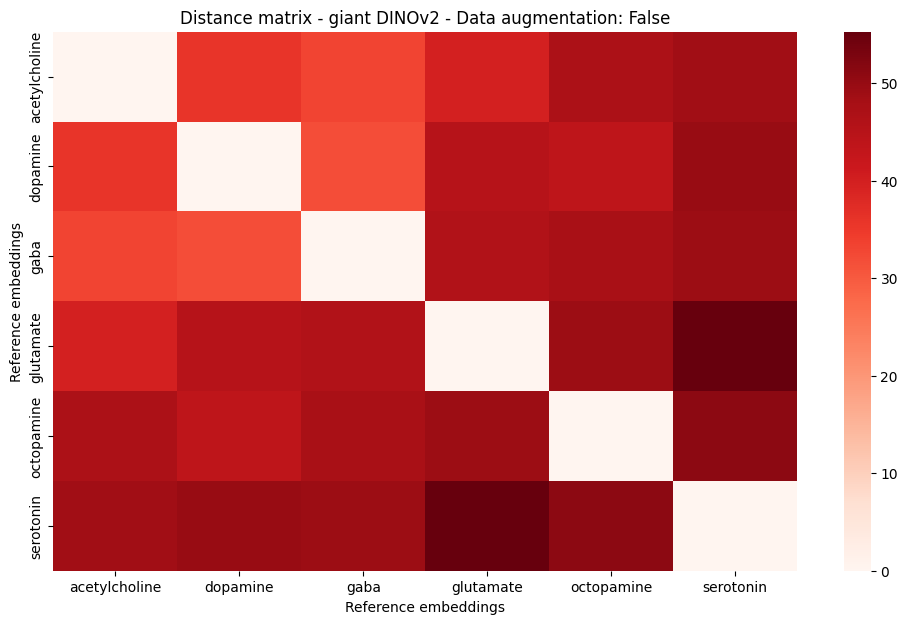

In [8]:
model_size = 'giant'
distance_matrix = euclidean_distances(mean_ref, mean_ref)
plt.figure(figsize=(12,7), dpi=100)
sns.heatmap(distance_matrix, xticklabels=neurotransmitters, yticklabels=neurotransmitters, cmap='Reds')
plt.title(f'Distance matrix - {model_size} DINOv2 - Data augmentation: {data_aug}')
plt.xlabel('Reference embeddings')
plt.ylabel('Reference embeddings')
plt.show()

In [10]:
print(f'The sum of distances is {np.sum(np.triu(distance_matrix, k=0))}')

The sum of distances is 674.0265502929688


In [11]:
diplay_features(
        np.vstack([ref_latents, np.vstack(mean_ref)]),
        np.hstack([ref_labels, np.hstack(mean_labs)]),

        include_pca=False,
        pca_nb_components=100,
        clustering=False,
        nb_clusters=6,
        nb_neighbor=10,
        min_dist=1,
        nb_components=2,
        metric='cosine'
    )

NameError: name 'mean_labs' is not defined

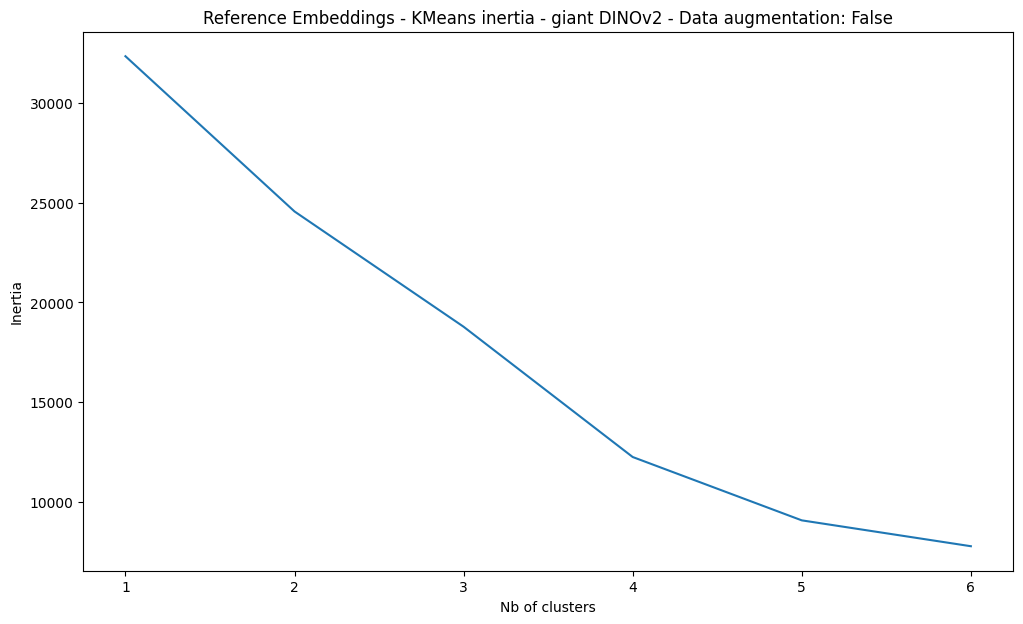

In [12]:
from sklearn.cluster import KMeans
inertia_list = []
for k in range(1,len(neurotransmitters)+1):
    kmeans = KMeans(n_clusters=k).fit(ref_latents)
    inertia_list.append(kmeans.inertia_)
plt.figure(figsize=(12,7),dpi=100)
plt.plot([i for i in range(1,len(neurotransmitters)+1)], inertia_list)
plt.title(f'Reference Embeddings - KMeans inertia - {model_size} DINOv2 - Data augmentation: {data_aug}')
plt.ylabel('Inertia')
plt.xlabel('Nb of clusters')
plt.show()

# Results 

In [ ]:
diplay_features(
        latents,
        labs,
        include_pca=False,
        pca_nb_components=100,
        clustering=False,
        nb_clusters=6,
        nb_neighbor=30,
        min_dist=1,
        nb_components=2,
        metric='cosine'
    )

/home/tomwelch/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.

/home/tomwelch/anaconda3/lib/python3.12/site-packages/umap/spectral.py:548: UserWarning:

Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!



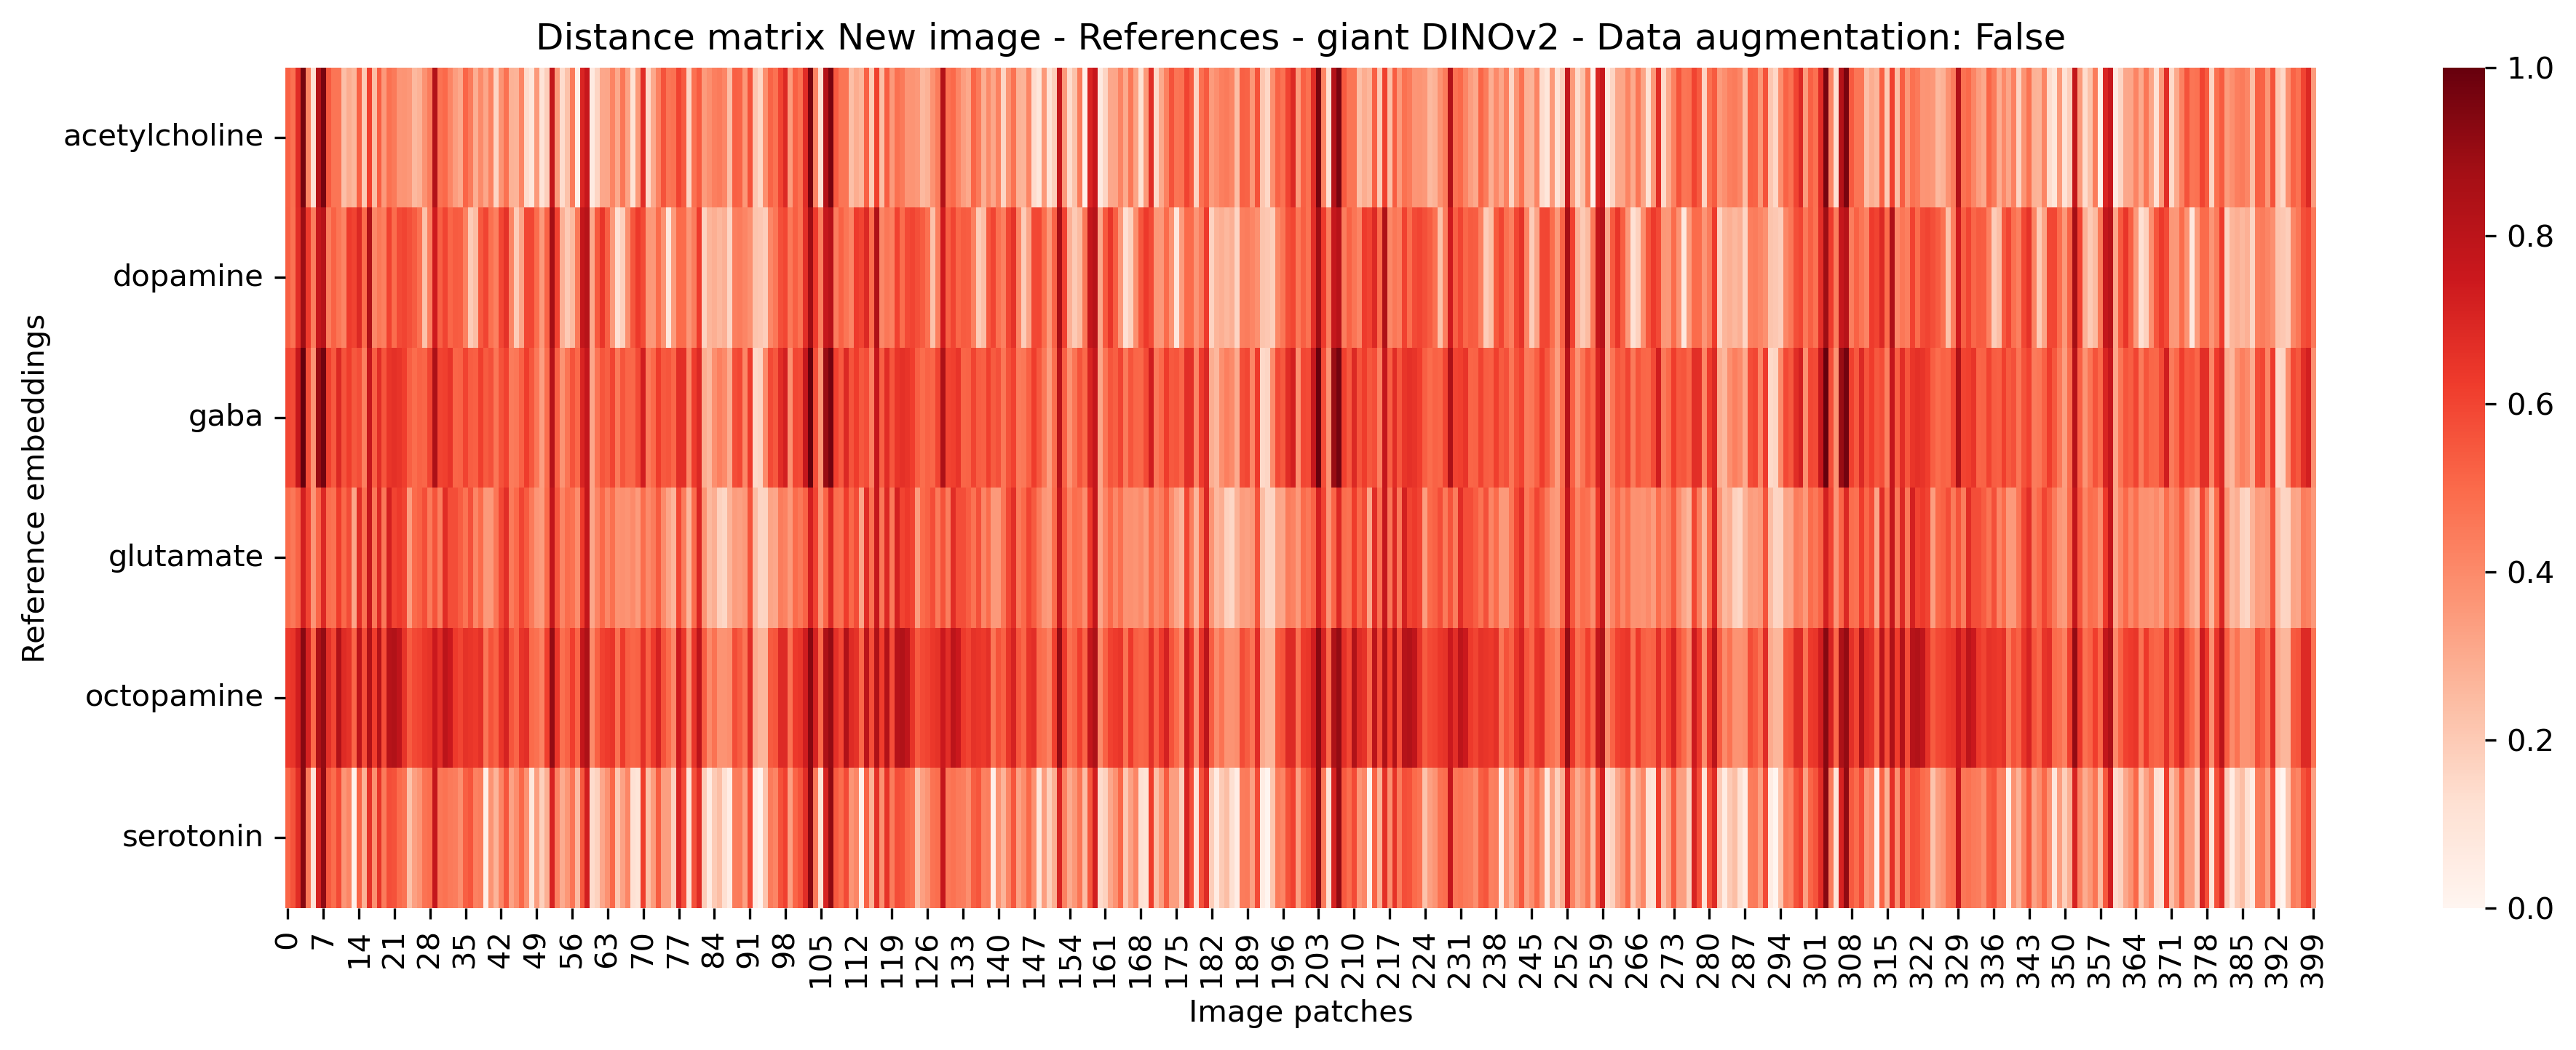

In [ ]:
test_similarity_matrix = euclidean_distances(mean_ref, new_img_embs)
test_similarity_matrix_normalized = (test_similarity_matrix - np.min(test_similarity_matrix)) / (np.max(test_similarity_matrix) - np.min(test_similarity_matrix))
plt.figure(figsize=(15,5),dpi=300)
sns.heatmap(test_similarity_matrix_normalized, yticklabels=mean_labs, cmap='Reds')
plt.title(f'Distance matrix New image - References - {model_size} DINOv2 - Data augmentation: {data_aug}')
plt.xlabel('Image patches')
plt.ylabel('Reference embeddings')
plt.show()

# Loading data embeddings

In [13]:
one_hot_neurotransmitters = np.zeros((len(neurotransmitters),len(neurotransmitters))) + np.identity(len(neurotransmitters))
emb_labels = np.hstack([[labels[i+1]]*240000 for i in range(0, 3600, 600)]).reshape(-1,1)

In [14]:
embeddings_saved = True

if embeddings_saved:
        new_embeddings = torch.load('/Users/tomw/Documents/MVA/Internship/Cambridge/Datasets/g_embs_140_140.pt') #TODO: for Mac
        #new_embeddings = torch.load('/home/tomwelch/Cambridge/Datasets/g_embs_140_140.pt') #TODO: for LINUX

else:
        
        images = np.array([load_image(file)[0] for file in tqdm(files, desc='Loading images')]).transpose(0,2,3,1)

        few_shot.pre_compute_embeddings(
                images,  # Pass numpy array of images
                overlap=(0.5, 0.5),
                padding=(0, 0),
                crop_shape=(518, 518, 1),
                verbose=True,
                batch_size=60
                )
        new_embeddings = few_shot.get_embs().reshape(-1, feat_dim)

        torch.save(new_embeddings, os.path.join(dataset_path, f'{model_size}_embs_{resize_size}_Aug={data_aug}_k={k}'))

# Results

In [20]:
def results(reference_embeddings = mean_ref, 
            test_embeddings = new_embeddings,
            metric = euclidean_distances,
            model_size = model_size,
            distance_threshold = 0.1,
            data_aug = True,
            Cross_Entropy_Loss = False,
            MSE_Loss = False):

    score_lists = [[],[],[],[],[],[]]

    similarity_matrix = metric(reference_embeddings, test_embeddings)
    similarity_matrix_normalized = (similarity_matrix - np.min(similarity_matrix)) / (np.max(similarity_matrix) - np.min(similarity_matrix))

    similarity_matrix_normalized_filtered = np.where(similarity_matrix_normalized <= distance_threshold, similarity_matrix_normalized, 0)

    for i, label in tqdm(enumerate(emb_labels)):

        column = similarity_matrix_normalized_filtered[:,i]

        if sum(column) == 0:
            pass
        else:
            if Cross_Entropy_Loss:
                pass 
            elif MSE_Loss:
                pass 
            else: 
                patch_wise_distances_filtered = np.where(column == 0, 1, column)

                output_class = one_hot_neurotransmitters[np.argmin(patch_wise_distances_filtered)]

                gt_index = neurotransmitters.index(label)
                ground_truth = one_hot_neurotransmitters[gt_index]
                score = np.sum(output_class*ground_truth)
                score_lists[gt_index].append(score)

    accuracies = [np.mean(scores)*100 for scores in score_lists]

    plt.figure(figsize=(12,7), dpi=300)
    plt.bar(neurotransmitters, accuracies)
    plt.xlabel('Classes')
    plt.ylabel('Mean hard accuracy')
    plt.title(f'Mean hard accuracies across classes - {model_size} DINOv2 - 140x140 images - Threshold = {distance_threshold} - Data augmentation: {data_aug}')
    plt.axhline(np.mean(accuracies), color='r', linestyle='--', label='Average')
    plt.axhline(y=(100/6), color='b', linestyle='--', label='Randomness')
    plt.legend()
    ax = plt.gca()
    ax.set_ylim([0,110])
    plt.show()
    
    return np.mean(accuracies)

1440000it [00:01, 1072888.66it/s]


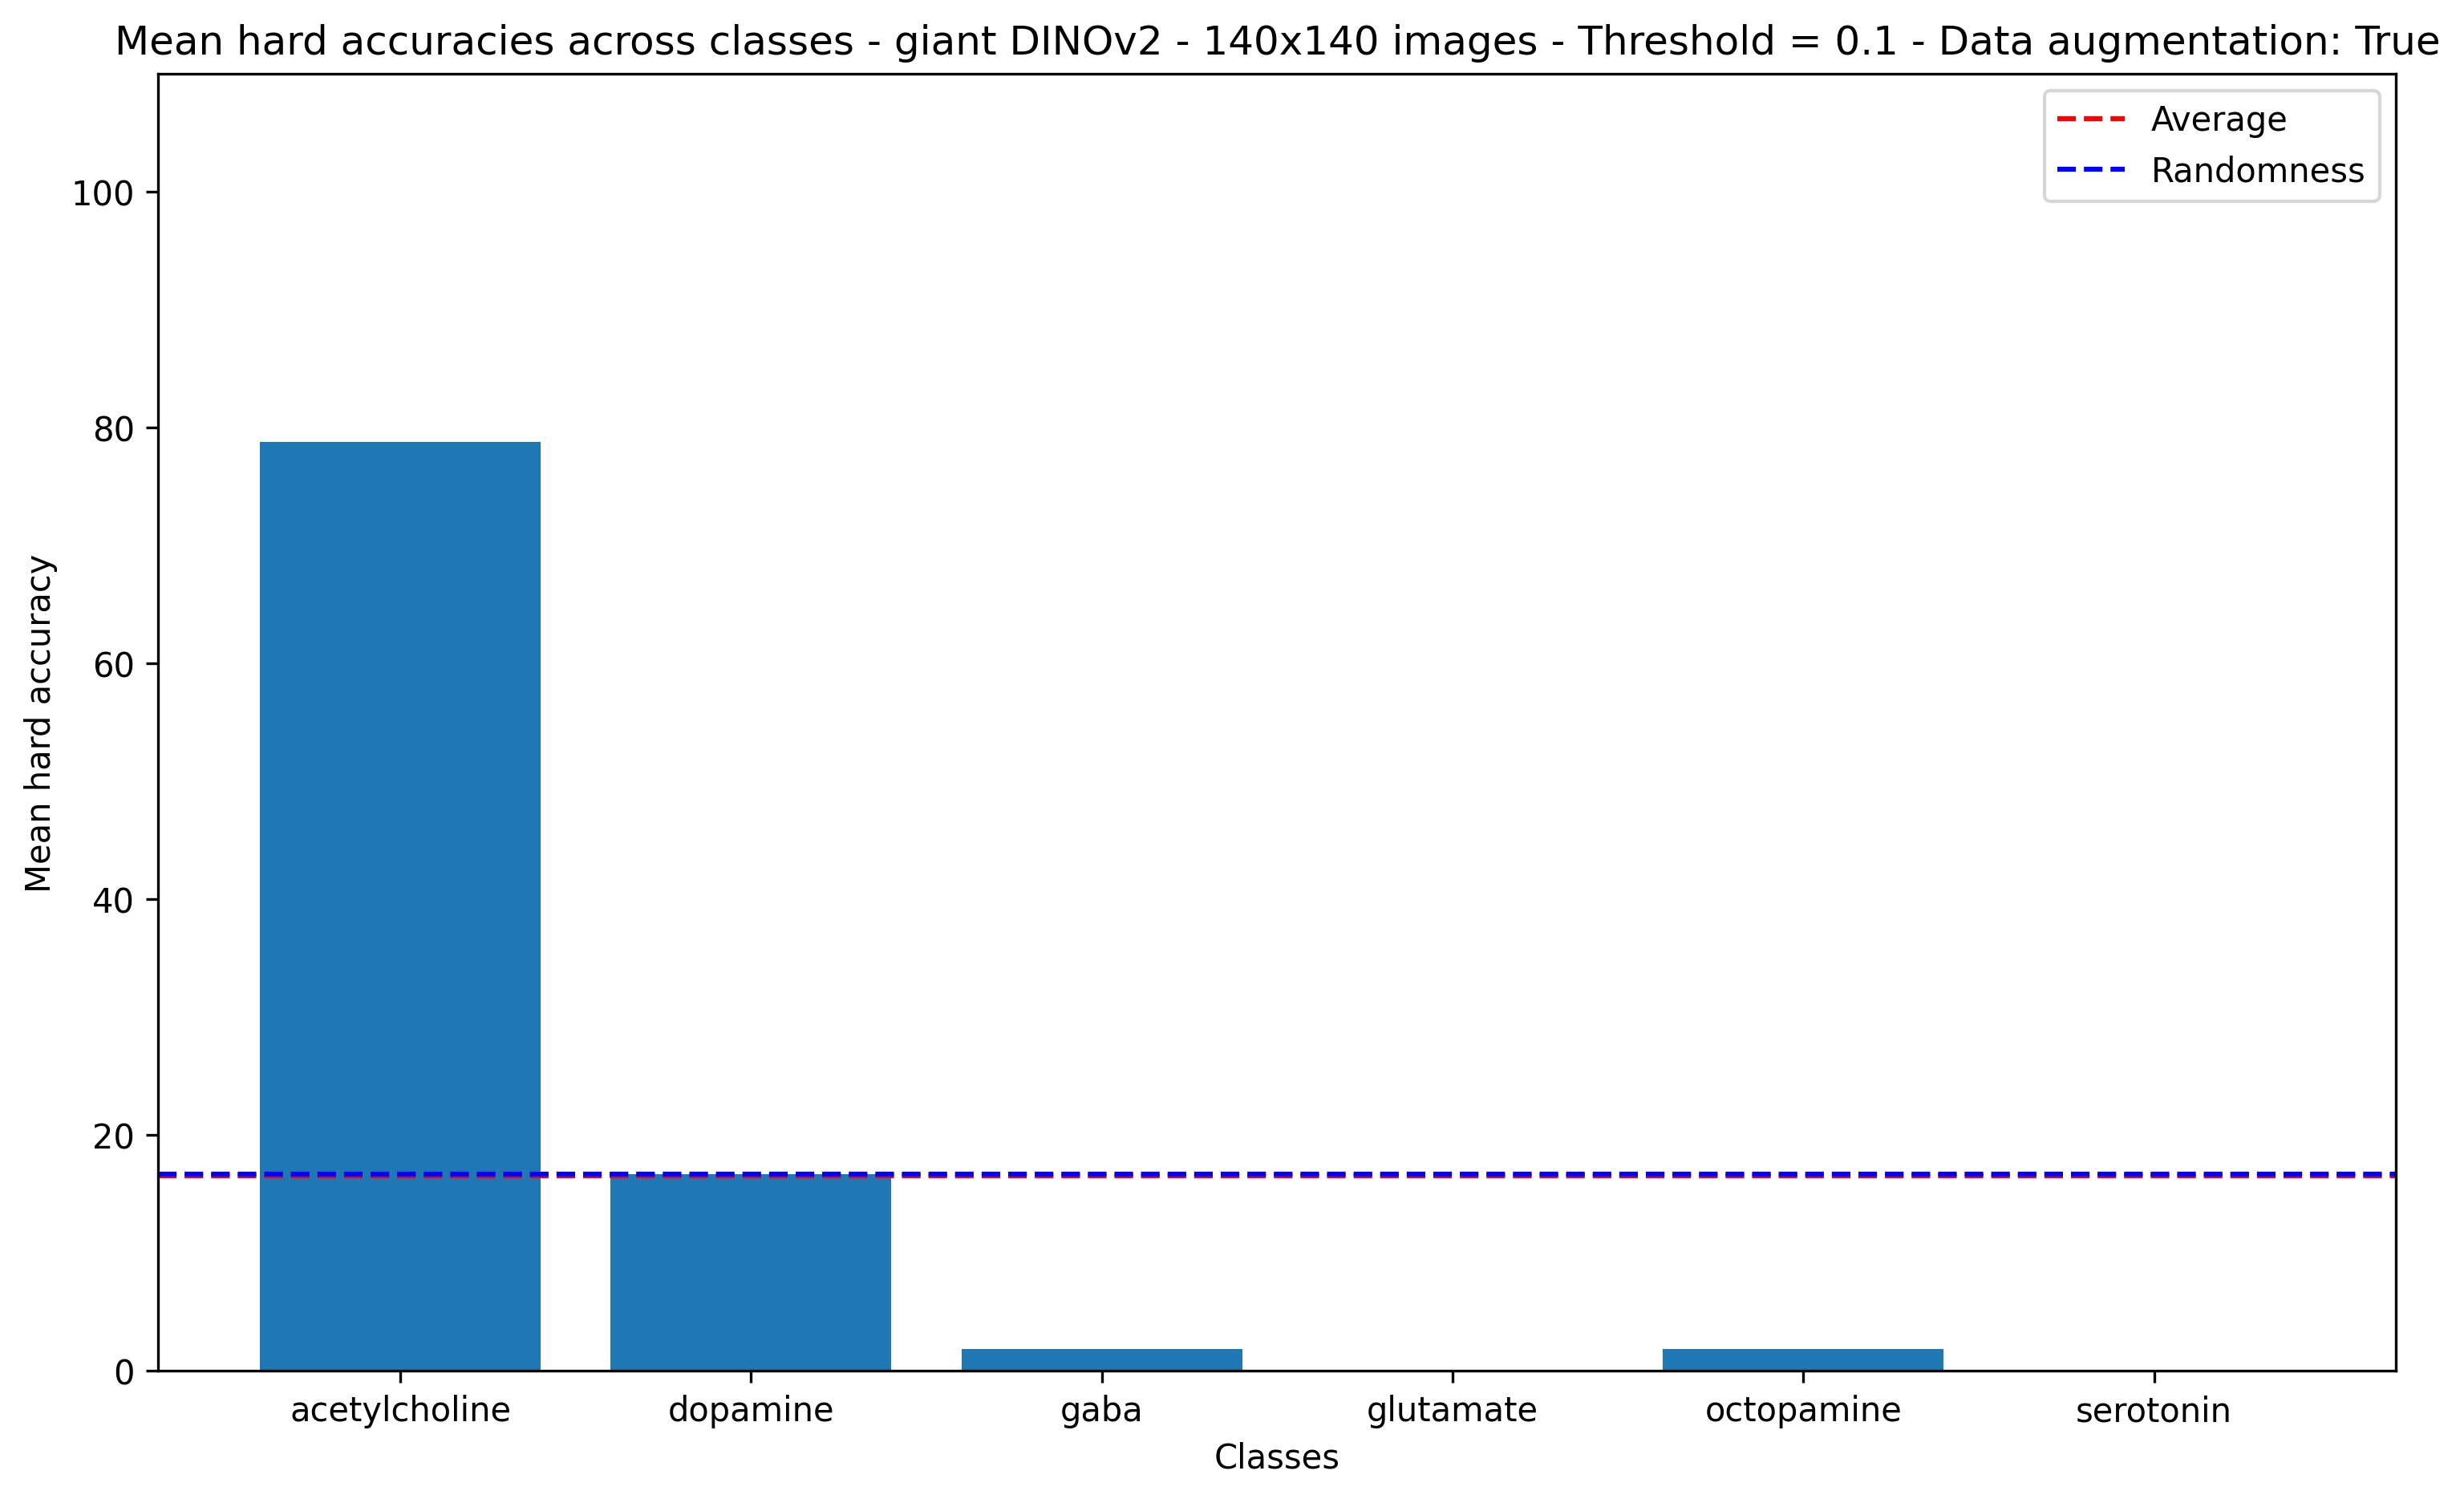

np.float64(16.52076318742985)

In [21]:
results()

# Results analysis

In [17]:
score_lists = [[],[],[],[],[],[]]
mean_accuracies_list, included_list = [], []

similarity_matrix = euclidean_distances(mean_ref, new_embeddings)
similarity_matrix_normalized = (similarity_matrix - np.min(similarity_matrix)) / (np.max(similarity_matrix) - np.min(similarity_matrix))

for distance_threshold in tqdm(np.arange(0.05, 1.025, 0.025)): 

    similarity_matrix_normalized_filtered = np.where(similarity_matrix_normalized <= distance_threshold, similarity_matrix_normalized, 0)
    
    included_list.append(len(np.where(similarity_matrix_normalized_filtered !=0)[0]))

    for i, label in enumerate(emb_labels):

        column = similarity_matrix_normalized_filtered[:,i]

        if sum(column) == 0:
            pass
        else:
            patch_wise_distances_filtered = np.where(column == 0, 1, column)

            output_class = one_hot_neurotransmitters[np.argmin(patch_wise_distances_filtered)]

            gt_index = neurotransmitters.index(label)
            ground_truth = one_hot_neurotransmitters[gt_index]
            score = np.sum(output_class*ground_truth)
            score_lists[gt_index].append(score)

    mean_accuracies_list.append(np.mean([np.mean(scores)*100 for scores in score_lists]))
    
included_list = [inclusion/(400*len(files)) for inclusion in included_list]

100%|██████████| 39/39 [03:59<00:00,  6.15s/it]


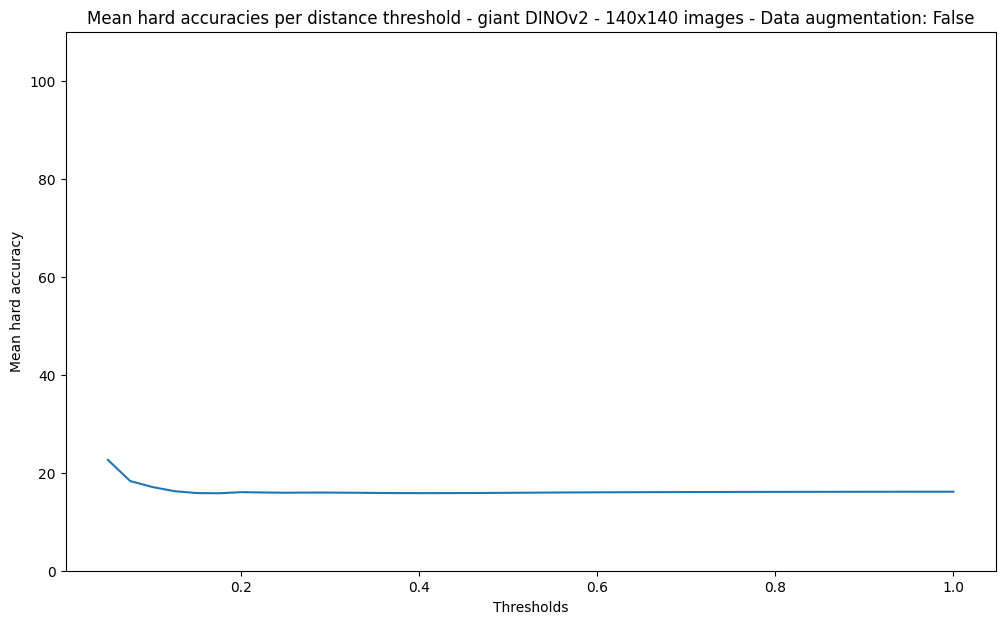

In [18]:
plt.figure(figsize=(12,7), dpi=100)
plt.plot([i for i in np.arange(0.05, 1.025, 0.025)], mean_accuracies_list)
plt.xlabel('Thresholds')
plt.ylabel('Mean hard accuracy')
plt.title(f'Mean hard accuracies per distance threshold - {model_size} DINOv2 - 140x140 images - Data augmentation: {data_aug}')
ax = plt.gca()
ax.set_ylim([0,110])
plt.show()

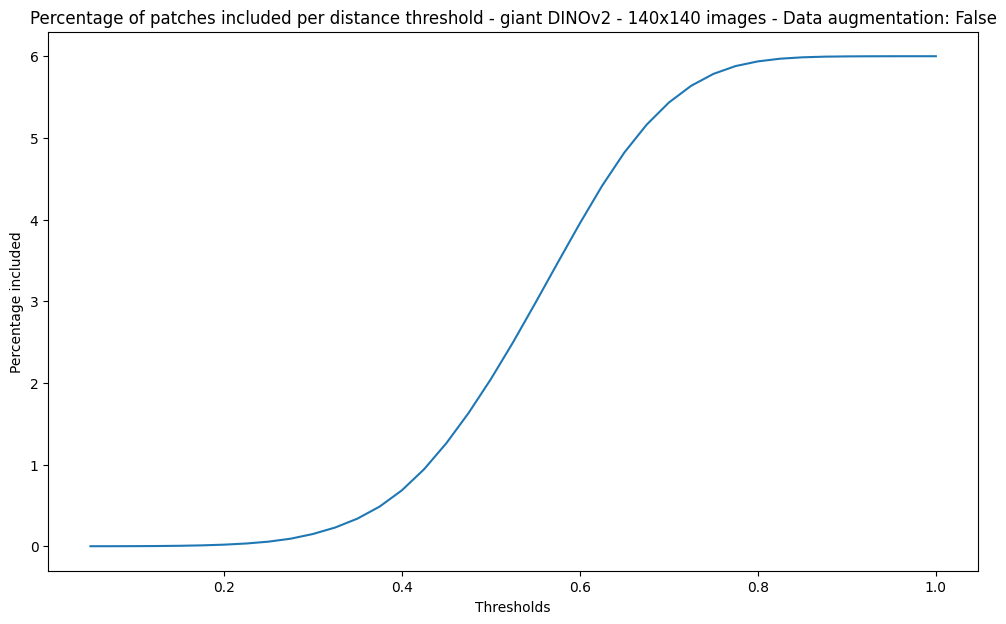

In [19]:
plt.figure(figsize=(12,7), dpi=100)
plt.plot([i for i in np.arange(0.05, 1.025, 0.025)], included_list)
plt.xlabel('Thresholds')
plt.ylabel('Percentage included')
plt.title(f'Percentage of patches included per distance threshold - {model_size} DINOv2 - 140x140 images - Data augmentation: {data_aug}')
ax = plt.gca()
#ax.set_ylim([0,110])
plt.show()